## <u>Bayesian GAM of Southern Ocean Chlorophyll Time Series</u>:
### <u>Part I - Single Zone Time Series</u>
by Erdem M. Karaköylü



### <u>Summary</u>
This notebook documents the development of alternative Bayesian Generalized Additive Models (GAM) to determine the components, such as trend, that make up a time series of chlorophyll. The region of interest is the Southern Ocean (SO). In particular, I focus on the Atlantic Ocean Sub-Tropical Zone (AOSTZ). The entire study follows a now [published paper](https://doi.org/10.1029/2019GL083163) on chlorophyll in the SO based on a shorter time series.

The progression of the notebook follows a increasing degree of complexity in the model design that I then fit the data. I use evaluation criteria that take the entire prediction posterior distribution of a model to estimate its predictive skill on out-of-sample data. These criteria include the Widely Available Information Criterion (WAIC) and the Pareto-Smoothed Importance Sampling Leave-One-Out Cross Validation (PSIS-LOOCV). I compare these criteria to select the better performing model or models.

The models developed below are coded using the Python probabilistic programming library [PyMC3](https://docs.pymc.io/).

In [1]:
# Import necessary library
import pathlib
import pickle
from collections import namedtuple
from platform import python_version as pv

import pandas as pd
import numpy as np
from numpy import pi as π
from sklearn.preprocessing import StandardScaler, scale

import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as pl
import matplotlib.dates as mdates
from matplotlib import rcParams
import arviz as ar

In [2]:
def print_ver(pkg):
    print(f'{pkg.__name__} version: {pkg.__version__}')
    
print(f'python version: {pv()}')
for p in [pd, np, pm, ar]:
    print_ver(p)

python version: 3.7.1
pandas version: 0.24.1
numpy version: 1.16.4
pymc3 version: 3.7
arviz version: 0.4.1


In [3]:
# Graphical settings
%matplotlib inline

years = mdates.YearLocator(day=1)
months = mdates.MonthLocator(bymonthday=1)
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.visible'] = True
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18
rcParams['axes.formatter.limits'] = (-3, 2)

The data is stored in a serialized (pickled) tabular [pandas](https://pandas.pydata.org/) dataframe and is loaded below

In [4]:
df = pd.read_pickle('../../pickleJar/df.pkl')

In [5]:
#quick formatting to remove empty spaces in column names
df.rename(columns={col: col.strip() for col in df.columns}, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 1997-09-01 to 2018-04-01
Data columns (total 14 columns):
sam        248 non-null float64
aao        248 non-null float64
iostz      248 non-null float64
iosostz    248 non-null float64
postz      248 non-null float64
posostz    248 non-null float64
aostz      248 non-null float64
aosostz    248 non-null float64
iopooz     241 non-null float64
popooz     188 non-null float64
aopooz     248 non-null float64
iosaaz     248 non-null float64
posaaz     248 non-null float64
aosaaz     248 non-null float64
dtypes: float64(14)
memory usage: 29.1 KB


The dataframe above contains time series 14 zones by which SO was divided. Their statistical properties are displayed below:

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sam,248.0,0.519879,1.701669,-5.770000,-0.642500,0.580000,1.652500,4.920000
aao,248.0,0.175113,0.973178,-2.798000,-0.448250,0.197000,0.884500,2.573000
iostz,248.0,0.213579,0.027127,0.142600,0.194450,0.217491,0.233288,0.287270
iosostz,248.0,0.216339,0.058586,0.147280,0.174935,0.201763,0.239613,0.641870
postz,248.0,0.201598,0.048607,0.110340,0.164000,0.197431,0.231166,0.335140
posostz,248.0,0.237798,0.107210,0.119390,0.163355,0.186825,0.289744,0.639570
aostz,248.0,0.292012,0.043535,0.199870,0.261736,0.281545,0.315765,0.415390
aosostz,248.0,0.363231,0.125154,0.182640,0.266058,0.342921,0.444249,0.969560
iopooz,241.0,0.197709,0.070319,0.128662,0.164502,0.180248,0.221227,1.067500
popooz,188.0,0.193421,0.057796,0.112061,0.150147,0.171223,0.226092,0.384627


I chose to use the AOSTZ timeseries as it is relatively clean with a full complement of observations. The data is displayed below. 

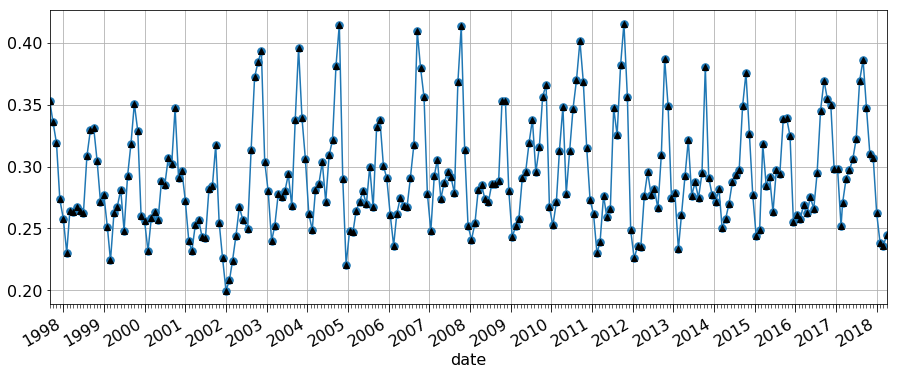

In [8]:
_, ax = pl.subplots(figsize=(15, 6))
df.aostz.plot(marker='.', ax=ax, markersize=15)
df.aostz.interpolate().plot(ls='', marker='^', color='k', ax=ax);
ax.xaxis_date()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.grid()

#### <u>Extracting and Standardizing the Data</u>

Model fitting is often best served by standardizing the data; namely, subtracting the mean and dividing by the standard deviation:

In [9]:
d_aostz = df['aostz'].resample('MS').mean().interpolate()
x = np.arange(d_aostz.size)
std_scaler = StandardScaler()
y_s = std_scaler.fit_transform(d_aostz.values[:,None])
y_s = y_s.flatten()

Save the training data:

In [13]:
datadict = dict(frame=d_aostz, x=x, y_s=y_s, scaler=std_scaler)
with open('../../pickleJar/datadict.pkl', 'wb') as fb:
    pickle.dump(datadict, fb, protocol=pickle.HIGHEST_PROTOCOL)

### <u>Model types and helper functions</u>
In order to avoid rewriting model definition code, I wrote a few functions to automate model creation. Three types of models, which are experimented with are wrapped in Python functions below:
1. Global linear trend only. This is essentially a linear regression model.
2. Global linear trend and fourier series-based seasonal cycle. Note that the number of fourier components can be specified during model instantiation.
3. Global trend, seasonal cyle and lag-1 autoregressive model.

In addition a fourier series helper function is also available to reduce code when fitting the seasonal cycle.

In [10]:
def mdl_trend_only(m):
    """
    m [pymc3 Model class]: model object
    """
    with m:
        σ = pm.Exponential('σ', 1)
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        μ = itc + slp * x
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

        
def fourier_series(x, p=12, n=1):
    wls = 2 * π * np.arange(1, n+1) / p
    newx = wls * x[:, None]
    sinusoids = np.concatenate((np.cos(newx), np.sin(newx)), axis=1)
    return sinusoids


def mdl_season_only(m, n_fourier):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    """
    with m:
        σ = pm.Exponential('σ', 1)
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(x, n=n_fourier), f_coefs)
        #tau = pm.Gamma('tau', 10, 2) 
        #y_lik = pm.StudentT('y_lik', mu=season, lam=tau, nu=nu_, observed=y_s)
        y_lik = pm.Normal('y_lik', mu=season, sd=σ, observed=y_s)

        
def mdl_trend_season(m, n_fourier):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    """
    with m:
        #season estimation
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(x, n=n_fourier), f_coefs)
        
        # linear trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * x)

        σ = pm.Exponential('σ', 1)
        
        μ = pm.Deterministic('mu', trend + season)
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

        
def mdl_trend_season_ar1(m, n_fourier):
    """
    m [pymc3 Model class]: model object
    n_fourier [int]: number of fourier components
    """
    with m:
        
        #season estimation
        f_coefs = pm.Normal('fourier_coefs', 0, sd=1, shape=(n_fourier*2))
        season = tt.dot(fourier_series(x, n=n_fourier), f_coefs)
        
        # linear trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * x)
        
        # residual estimation
        k_ = pm.Uniform('k', -1.1, 1.1)
        tau_ = pm.Gamma('tau', 10, 3)
        ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y_s.size)
        
        σ = pm.Exponential('σ', 1)
        
        μ = pm.Deterministic('mu', trend + season + ar1)
        y_lik = pm.Normal('y_lik', mu=μ, sd=σ, observed=y_s)

### <u>Model Implementations</u>
#### 1. <u>Linear Trend Model</u>

In [11]:
m1 = pm.Model()
mdl_trend_only(m1)
with m1:
    trace_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, σ]
Sampling 4 chains: 100%|██████████| 28000/28000 [00:16<00:00, 1734.16draws/s]


In [35]:
render = pm.model_to_graphviz(m1)
render.format = 'png'
render.render('model1_linear_trend', directory='../../figjar/model1_linear_trend.png')

'../../figjar/model1_linear_trend.png'

A [Kruschke](https://www.elsevier.com/books/doing-bayesian-data-analysis/kruschke/978-0-12-405888-0) diagram summarizes the linear trend model structure below:

<img src='../../figjar/model1_linear_trend.png' />

In [39]:
m1.name='linear_trend'

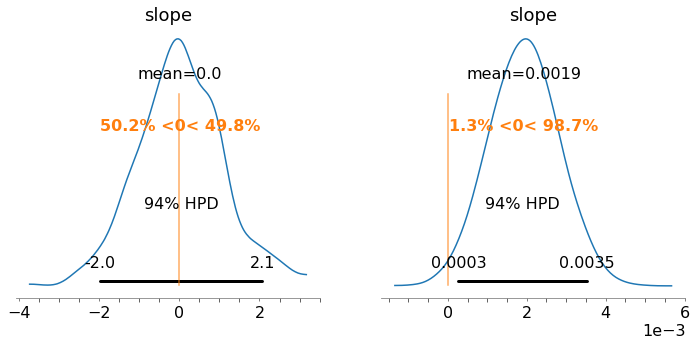

In [14]:
f, ax = pl.subplots(ncols=2, figsize=(12, 5))
ar.plot_posterior(m1_inference.prior, var_names=['slope'], ax=ax[0], ref_val=0);
ar.plot_posterior(m1_inference.posterior, var_names=['slope'], ax=ax[1], ref_val=0, round_to=4);

In [15]:
dict_final_comparison={'m1_trend_only': m1_inference}

#### 2. <u>Fourier-based seasonal cycle models</u><br>
Below I try a number of models differing in the number of fourier components used in the approximation. Initially I forego the trend and focus on the seasonal cycle only<br>
\\(\rightarrow\\)3 fourier components (6 coefficients):

In [16]:
m2_f3 = pm.Model()
mdl_season_only(m2_f3, n_fourier=3)

In [17]:
render2 = pm.model_to_graphviz(m2_f3)
render2.format='png'
render2.render('fourier_only', directory='../../figjar/');

Kruschke diagram of the seasonaly cycle-only model:

<img src='../../figjar/fourier_only.png' />

In [18]:
with m2_f3:
    trace_m2f3 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1430.52draws/s]


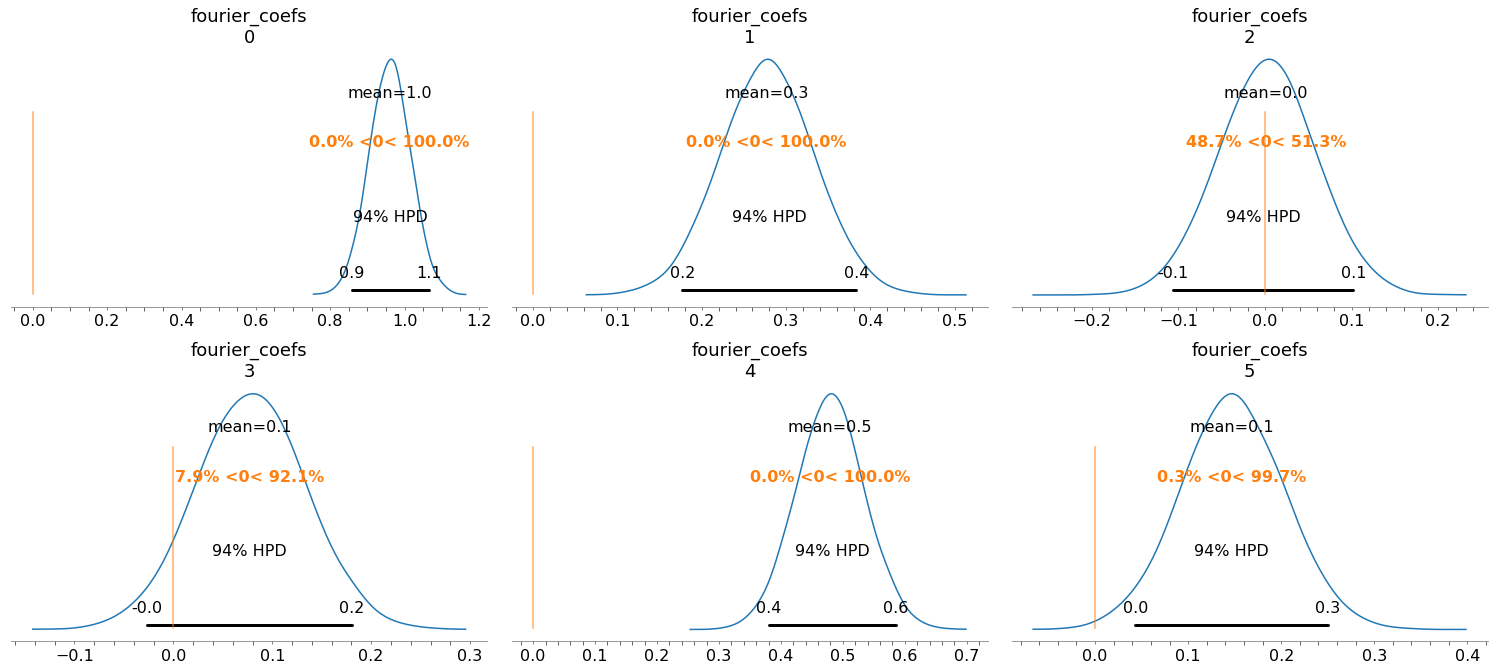

In [19]:
ar.plot_posterior(trace_m2f3, var_names=['fourier_coefs'], ref_val=0);

\\(\rightarrow\\) 5 fourier components (10 coefficients)

In [20]:
m2_f5 = pm.Model()
mdl_season_only(m2_f5, n_fourier=5)

In [21]:
with m2_f5:
    trace_m2f5 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:32<00:00, 1217.11draws/s]


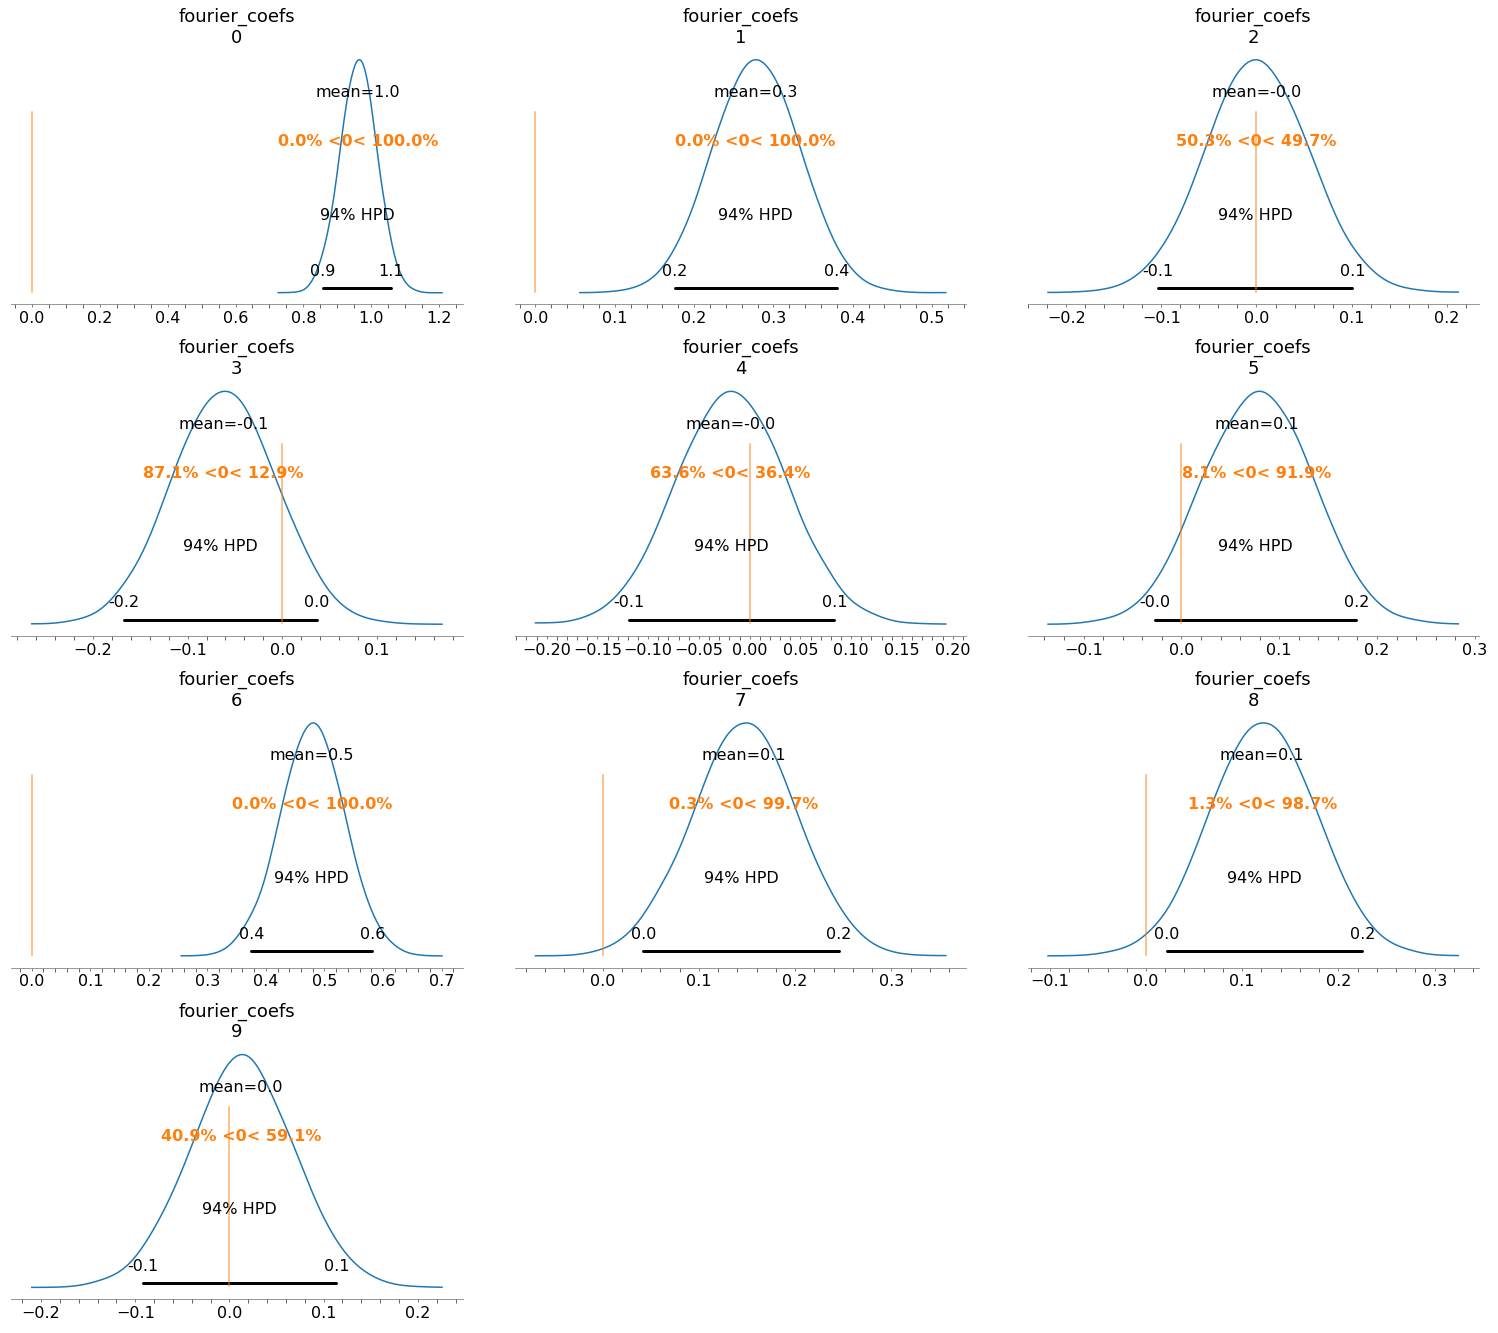

In [22]:
ar.plot_posterior(trace_m2f5, var_names=['fourier_coefs'], ref_val=0);

\\(\rightarrow\\)7 fourier components

In [23]:
m2_f7 = pm.Model()
mdl_season_only(m2_f7, n_fourier=7)

In [24]:
with m2_f7:
    trace_m2f7 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:55<00:00, 726.36draws/s]


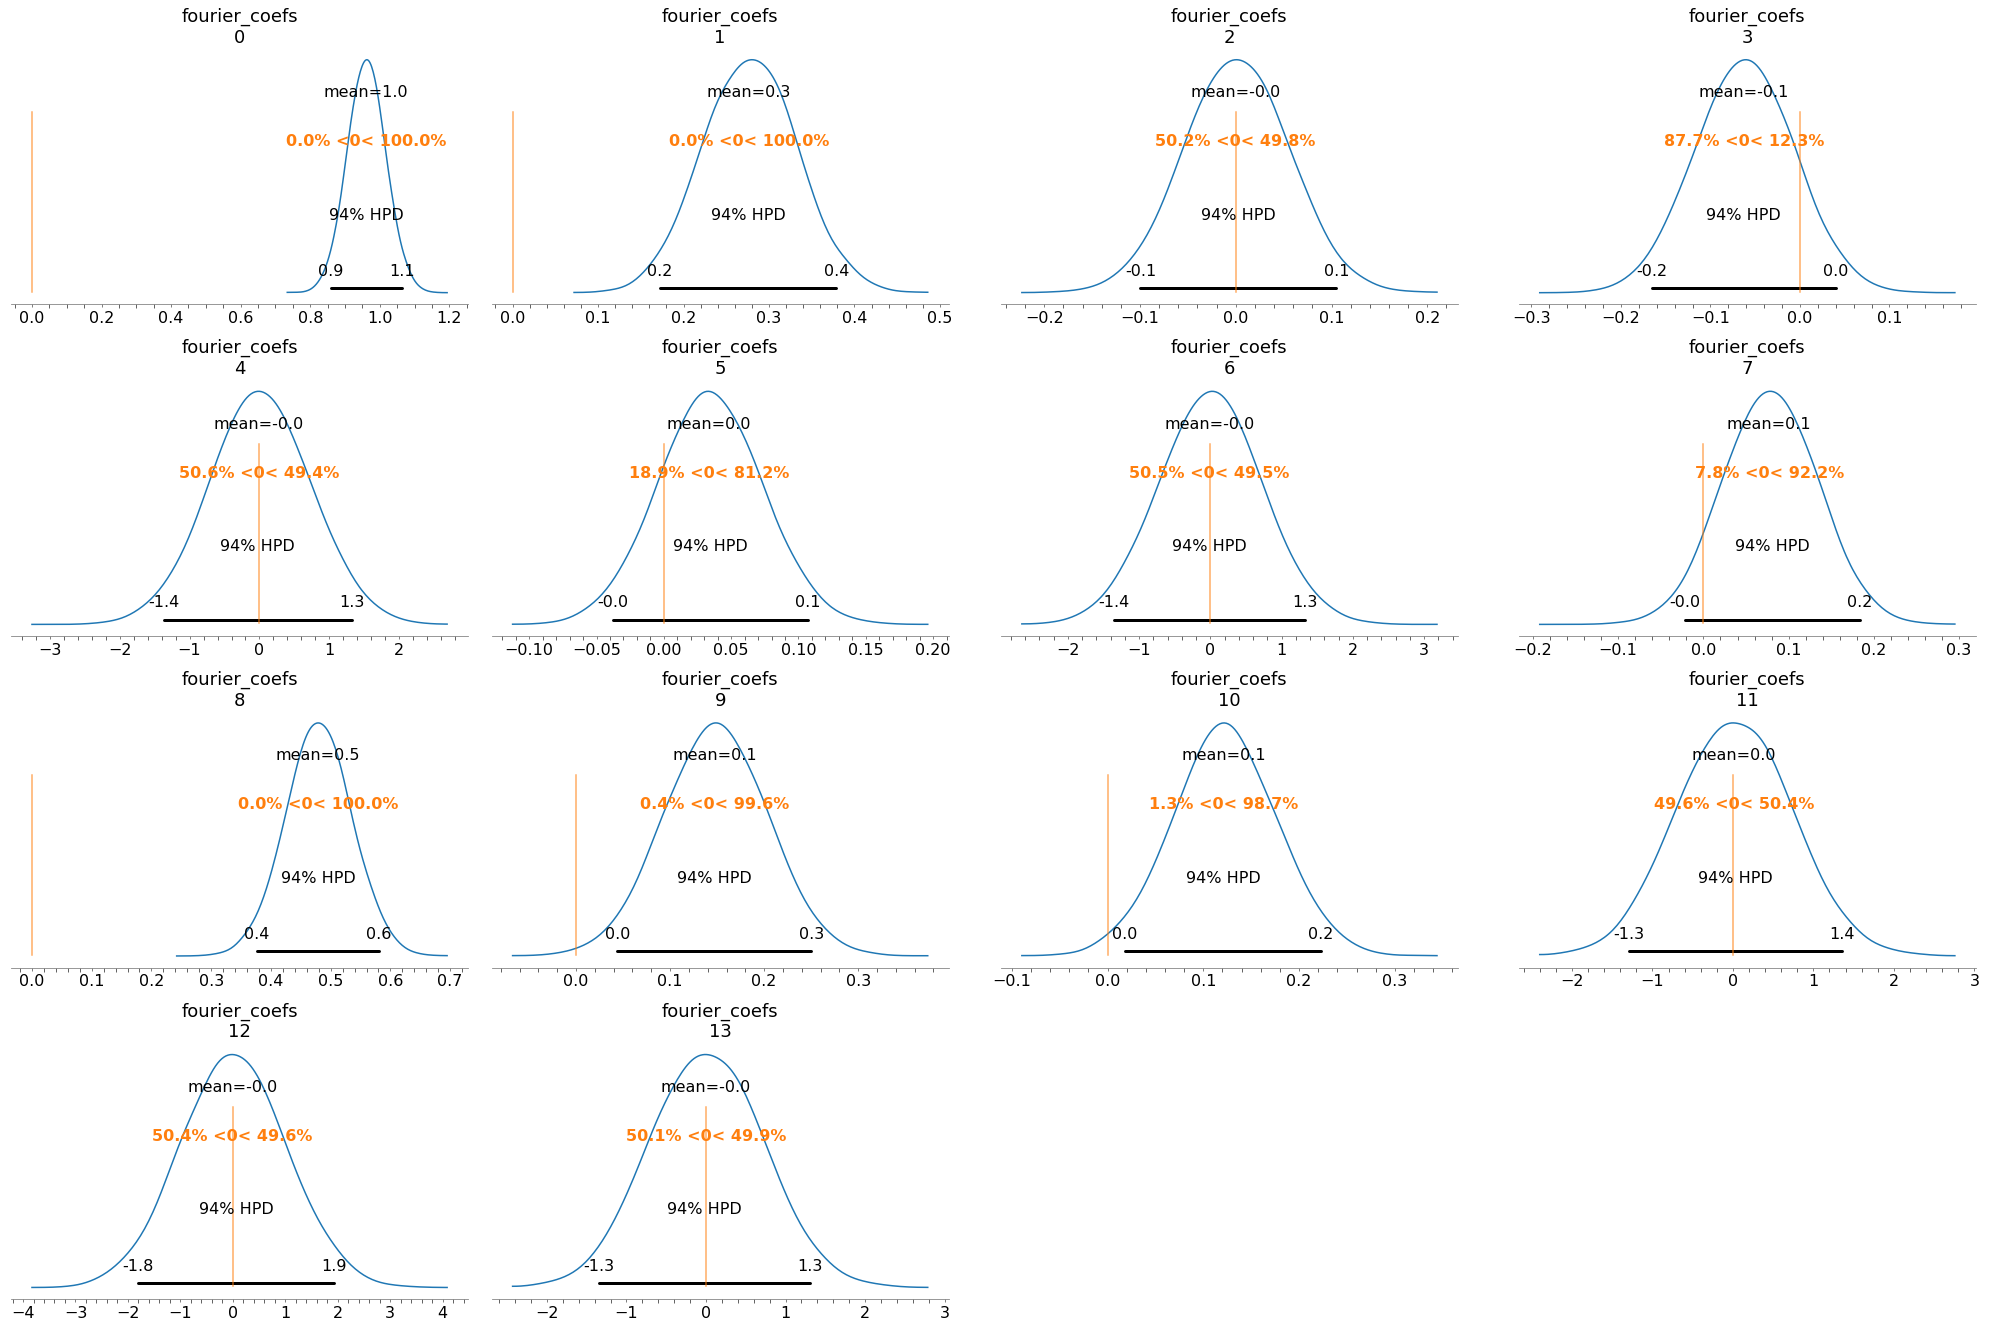

In [25]:
pm.plot_posterior(trace_m2f7, var_names=['fourier_coefs'], ref_val=0);

\\(\rightarrow\\)4 fourier components

In [26]:
m2_f4 = pm.Model()
mdl_season_only(m2_f4, n_fourier=4)

In [27]:
with m2_f4:
    trace_m2f4 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:11<00:00, 3456.03draws/s]


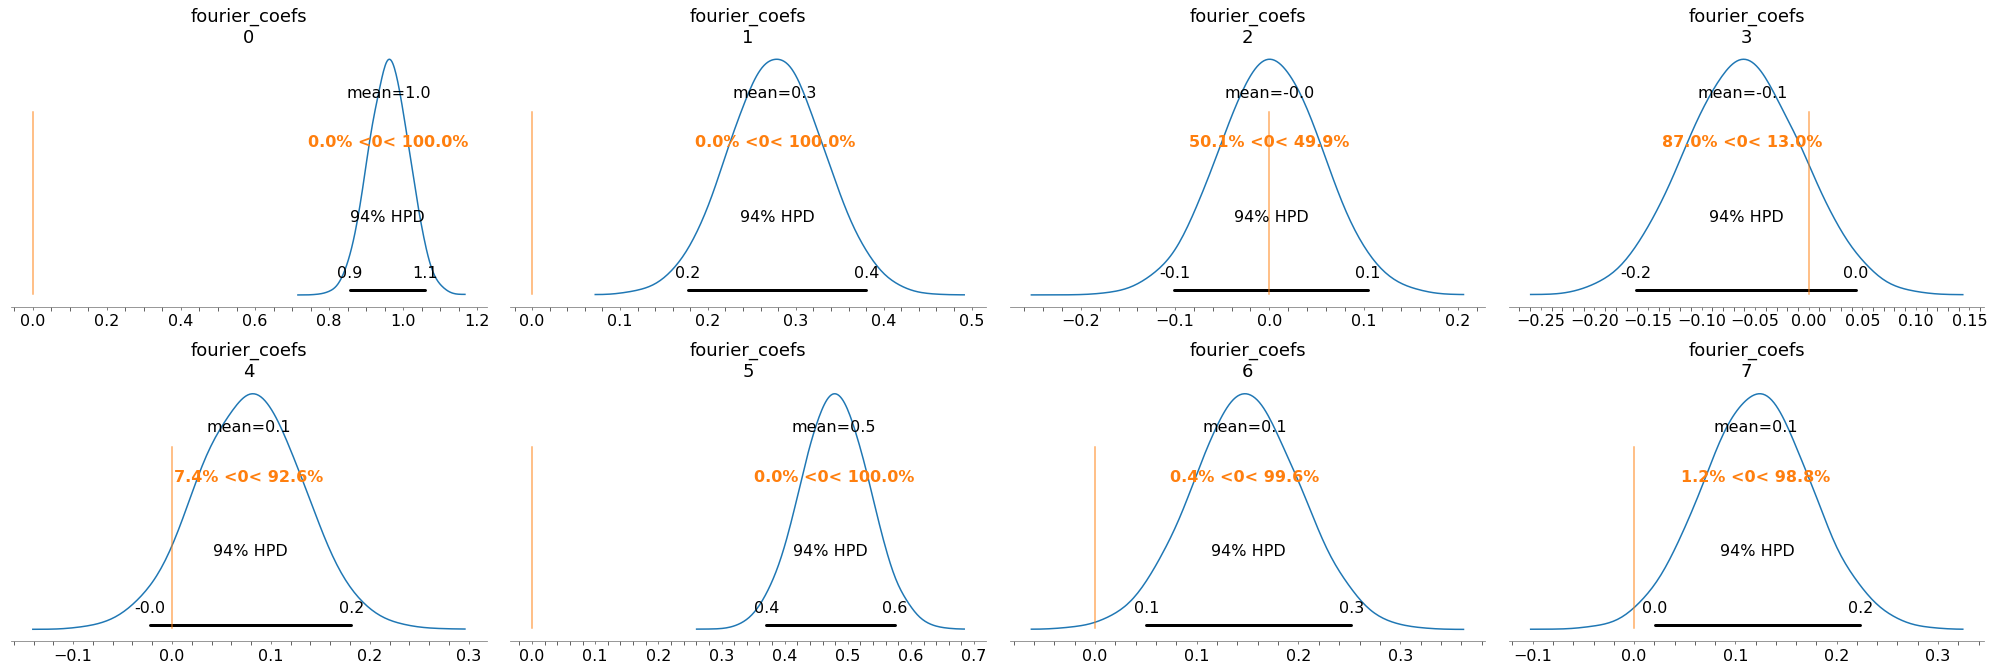

In [28]:
pm.plot_posterior(trace_m2f4, var_names=['fourier_coefs'], ref_val=0);

\\(\rightarrow\\) single fourier component

In [29]:
m2_f1 = pm.Model()
mdl_season_only(m2_f1, n_fourier=1)

In [30]:
with m2_f1:
    trace_m2f1 = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [fourier_coefs, σ]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:06<00:00, 6160.00draws/s]


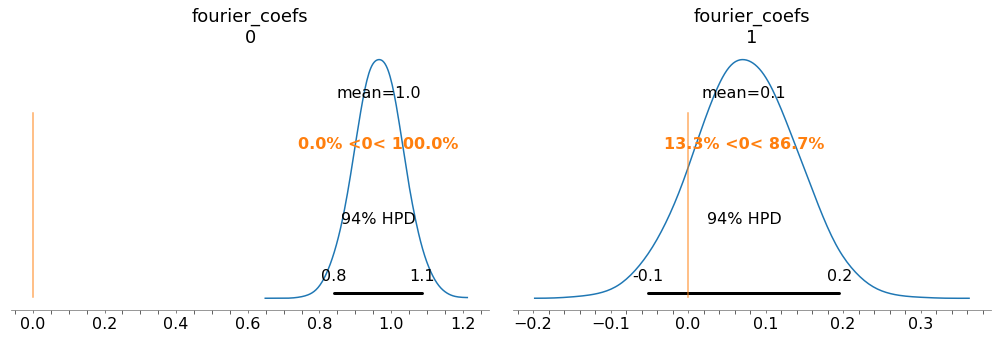

In [31]:
pm.plot_posterior(trace_m2f1, var_names=['fourier_coefs'], ref_val=0);

<u>Comparing predicted performance on out-of-sample data (with WAIC)</u>:

In [40]:
m2_f1.name = 'fourier_N1'
m2_f3.name = 'fourier_N3'
m2_f4.name = 'fourier_N4'
m2_f5.name = 'fourier_N5'
m2_f7.name = 'fourier_N7'

In [41]:
dict_fourier = {m2_f1.name: trace_m2f1, m2_f3.name: trace_m2f3,
                m2_f4.name: trace_m2f4, m2_f5.name: trace_m2f5,
                m2_f7.name: trace_m2f7,}
ar.compare(dict_fourier)

/accounts/ekarakoy/anaconda3/envs/bayesian_toa_project/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
fourier_N4,461.612,8.86307,0,0.564934,22.6605,0,False,deviance
fourier_N3,464.235,7.05497,2.62349,0.301682,22.9062,4.97552,False,deviance
fourier_N5,465.695,10.8373,4.08389,0.0809954,22.8387,0.873804,False,deviance
fourier_N7,466.964,11.8117,5.35208,0.0523887,23.0219,1.75894,True,deviance
fourier_N1,549.924,3.08941,88.3129,5.61604e-11,22.6819,17.2934,False,deviance


The table above confirms that a 4-component fourier series model approximates well the yearly seasonal cycle in the data, and the 3-component one is not too far behind. I'll retain those two for further evaluation. For good measure I'll compare these two with the linear trend model:

In [42]:
ar.compare({m1.name: trace_1, m2_f3.name: trace_m2f3, m2_f4.name: trace_m2f4})

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
fourier_N4,461.612,8.86307,0,0.66738,23.1237,0,False,deviance
fourier_N3,464.235,7.05497,2.62349,0.33262,23.0245,4.97552,False,deviance
linear_trend,704.919,2.90999,243.307,2.92328e-35,22.7794,25.3232,False,deviance


Based on the above, only I'll retain the 3- and 4-component fourier models:

In [43]:
m2_f3_inference = ar.from_pymc3(trace=trace_m2f3, 
                                prior=pm.sample_prior_predictive(model=m2_f3),
                                posterior_predictive=pm.sample_posterior_predictive(trace_m2f3, model=m2_f3))

100%|██████████| 20000/20000 [00:12<00:00, 1562.36it/s]


In [44]:
m2_f4_inference = ar.from_pymc3(trace=trace_m2f4, prior=pm.sample_prior_predictive(model=m2_f4),
                               posterior_predictive=pm.sample_posterior_predictive(trace_m2f4, model=m2_f4))

100%|██████████| 20000/20000 [00:12<00:00, 1561.47it/s]


In [49]:
m2_f3_inference.to_netcdf('../../pickleJar/model_results_nc/m2f3.nc')
m2_f4_inference.to_netcdf('../../pickleJar/model_results_nc/m2f4.nc')

'../../pickleJar/model_results_nc/m2f4.nc'

### Trend + Seasonality

I'll use 3- and 4-component fourier series to model seasonality on top of a global trend.

In [50]:
m3_f4 = pm.Model()
mdl_trend_season(m3_f4, n_fourier=4)

In [51]:
render_m3_f4 = pm.model_to_graphviz(m3_f4)
render_m3_f4.format='png'
render_m3_f4.render('m3_linear_&_f4', directory='../../figjar/')

'../../figjar/m3_linear_&_f4.png'

<img src='../../figjar/m3_linear_&_f4.png' />

In [52]:
with m3_f4:
    trace_m3f4 = pm.sample(5000, tune=25000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:39<00:00, 3032.20draws/s]
The acceptance probability does not match the target. It is 0.6948791746955983, but should be close to 0.8. Try to increase the number of tuning steps.


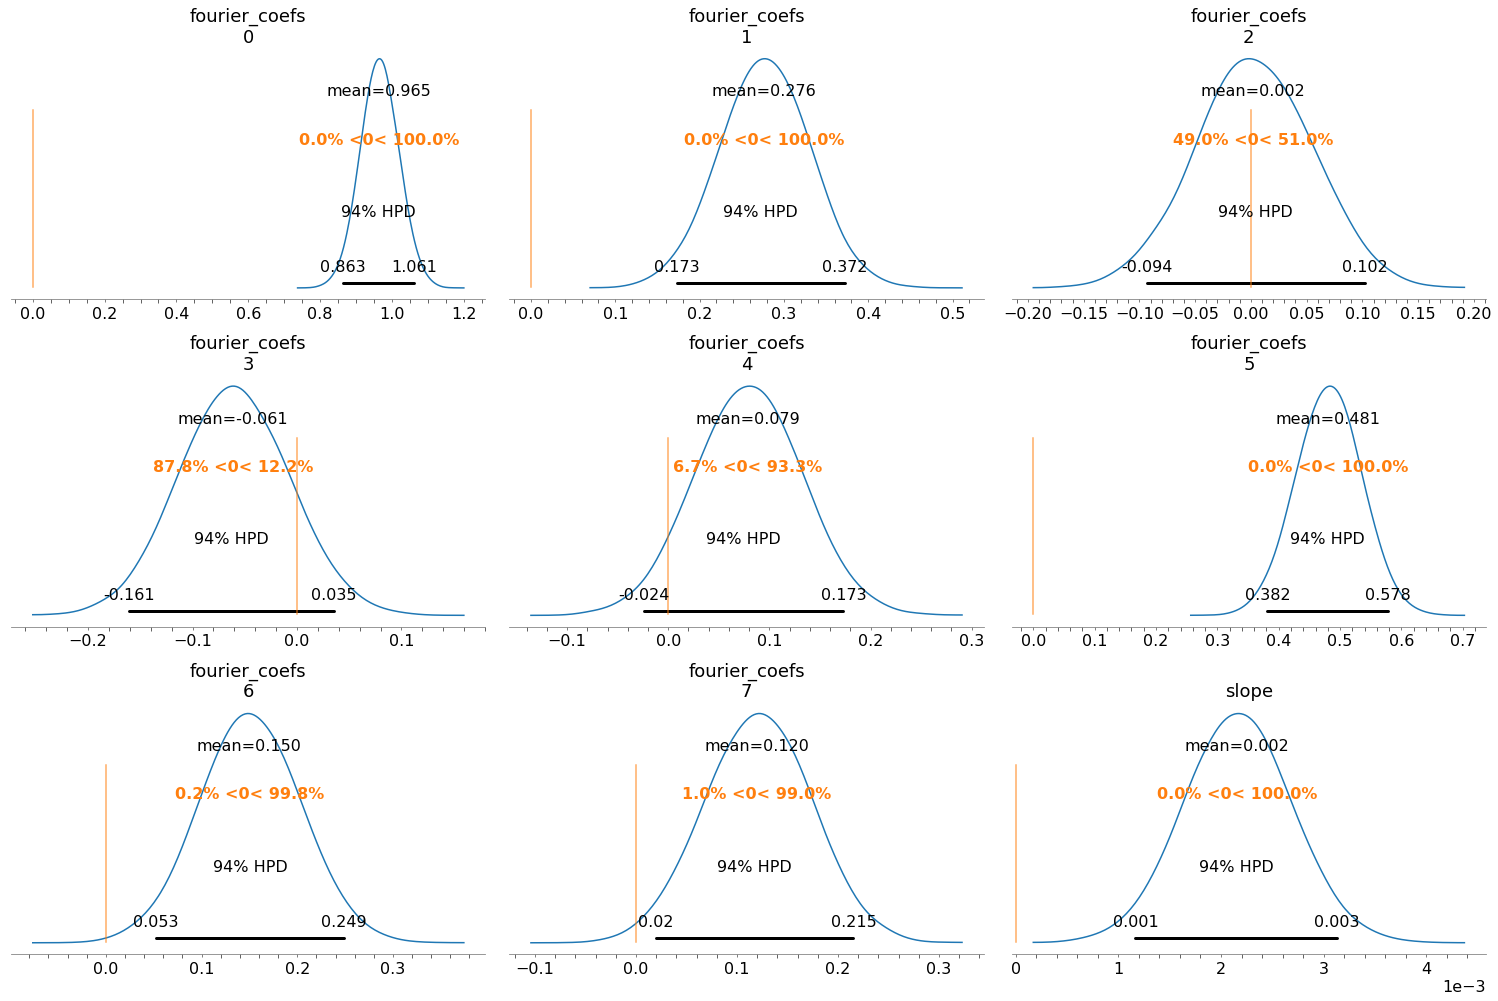

In [53]:
vars_ = ['fourier_coefs', 'slope',]
pm.plot_posterior(trace_m3f4, var_names=vars_, ref_val=0, round_to=3);

In [54]:
m3_f3 = pm.Model()
mdl_trend_season(m3_f3, n_fourier=3)

In [55]:
with m3_f3:
    trace_m3f3 = pm.sample(5000, tune=25000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 120000/120000 [00:38<00:00, 3115.92draws/s]


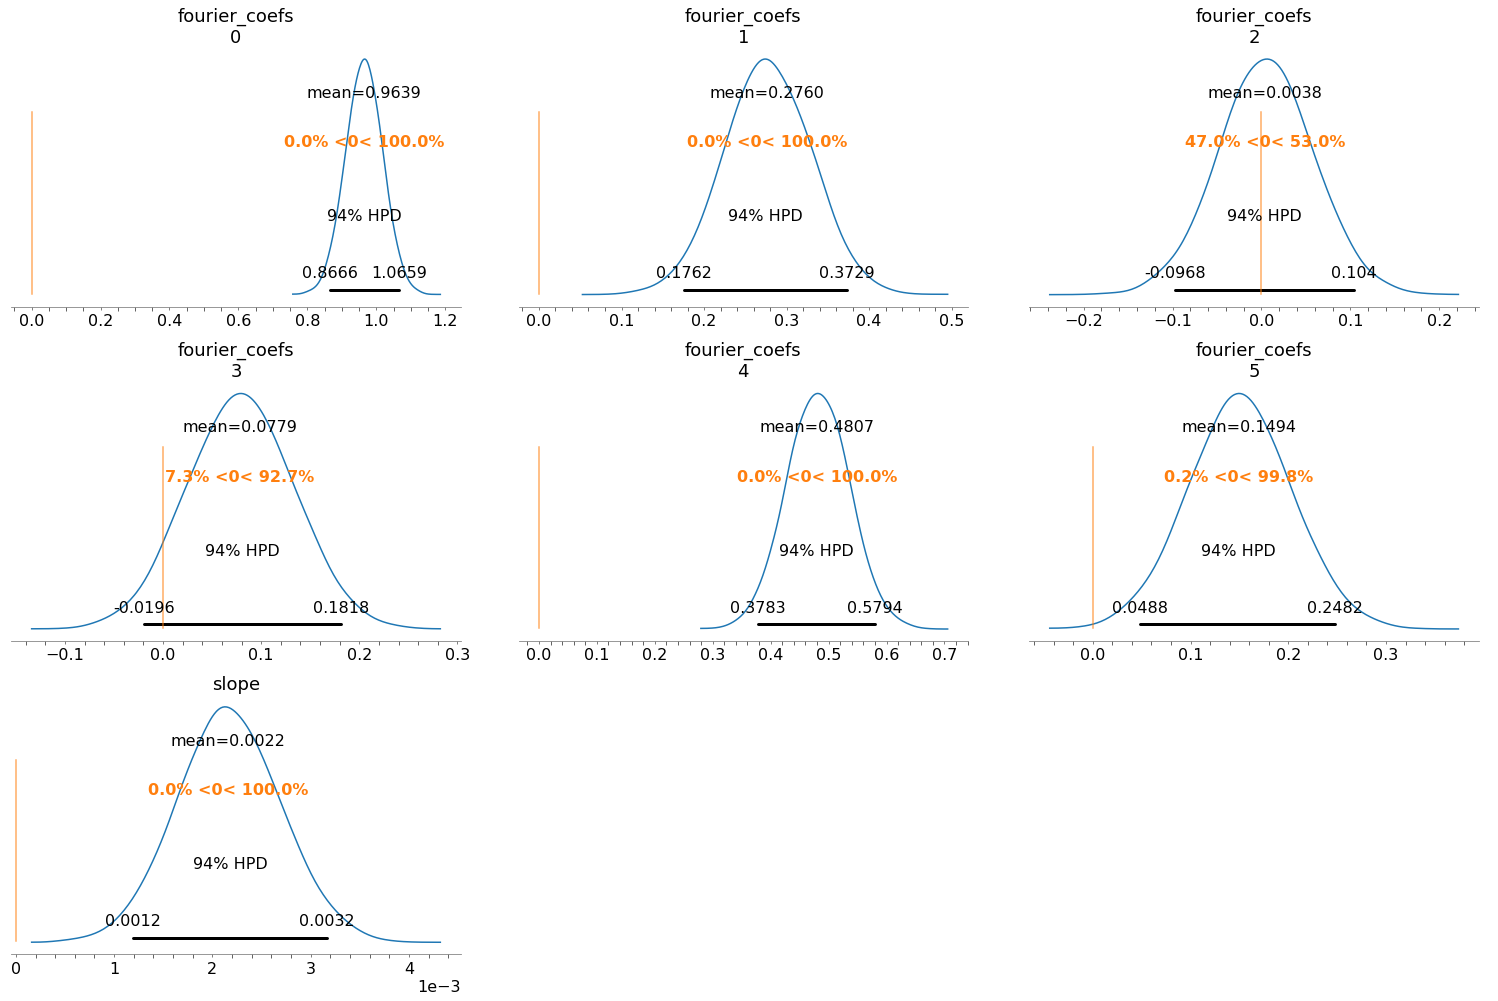

In [56]:
pm.plot_posterior(trace_m3f3, var_names=vars_, ref_val=0, round_to=4);

In [57]:
m3_f4.name ='m3_trend&fourierN4'
m3_f3.name = 'm3_trend&fourierN3'

In [ ]:
pm.compare({m3_f4: trace_m3f4, m3_f3: trace_m3f3,})

In [ ]:
pm.compare({m2_f3: trace_m2f3, m2_f4: trace_m2f4 }, ic='LOO')

In [58]:
ar.compare({m3_f4.name: trace_m3f4, m3_f3.name: trace_m3f3,
            m2_f3.name: trace_m2f3, m2_f4.name: trace_m2f4})

/accounts/ekarakoy/anaconda3/envs/bayesian_toa_project/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m3_trend&fourierN4,448.018,10.5493,0,0.63857,23.9643,0,True,deviance
m3_trend&fourierN3,450.858,8.71287,2.83947,0.319662,24.0971,5.06291,False,deviance
fourier_N4,461.612,8.86307,13.5933,0.0287869,24.562,7.22479,False,deviance
fourier_N3,464.235,7.05497,16.2168,0.0129813,24.6483,8.34353,False,deviance


The above satisfies the sanity check that adding the linear trend to the fourier season approximation results in improved performance. I'll retain therefore those two models for further evaluation. Next is to add AR1 noise:

### Trend + Season + AR1 Residual

In [59]:
m4_f4 = pm.Model()
mdl_trend_season_ar1(m4_f4, n_fourier=4)

In [60]:
render_m4_f4 = pm.model_to_graphviz(m4_f4)
render_m4_f4.format = 'png'
render_m4_f4.render('m_linear_&_fourier_season_ar1', directory='../../figjar/')

'../../figjar/m_linear_&_fourier_season_ar1.png'

<img src='../../figjar/m_linear_&_fourier_season_ar1.png' />

In [61]:
with m4_f4:
    trace_m4f4 = pm.sample(5000, tune=30000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, ar1, tau, k, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 140000/140000 [05:01<00:00, 464.18draws/s]
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
There were 524 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6180755365431909, but should be close to 0.8. Try to increase the number of tuning steps.
There were 247 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6958305912901757, but should be close to 0.8. Try to increase the number of tuning steps.
There were 409 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7110306609543241, but should be close to

In [62]:
m4_f3 = pm.Model()
mdl_trend_season_ar1(m4_f3, n_fourier=3)
with m4_f3:
    trace_m4f3 = pm.sample(5000, tune=30000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, ar1, tau, k, intercept, slope, fourier_coefs]
Sampling 4 chains: 100%|██████████| 140000/140000 [05:12<00:00, 447.60draws/s] 
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.06901057643314923, but should be close to 0.8. Try to increase the number of tuning steps.
There were 751 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6880328540318185, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1102 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6481264880229297, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2084 divergences after tuni

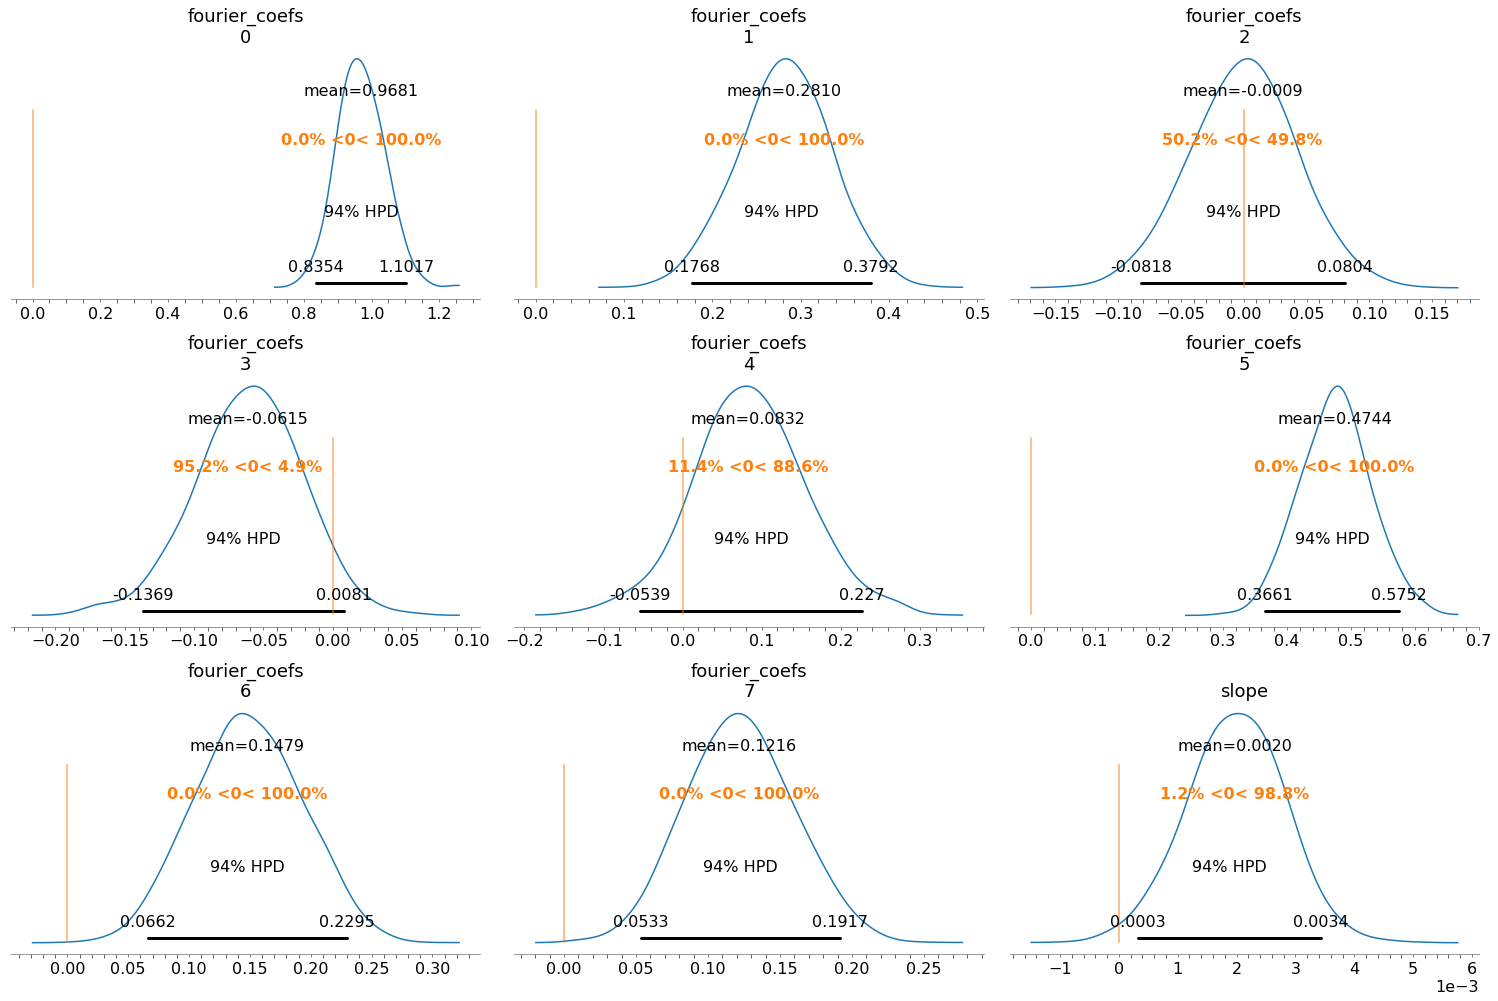

In [63]:
pm.plot_posterior(trace_m4f4, var_names=vars_, ref_val=0, round_to=4);

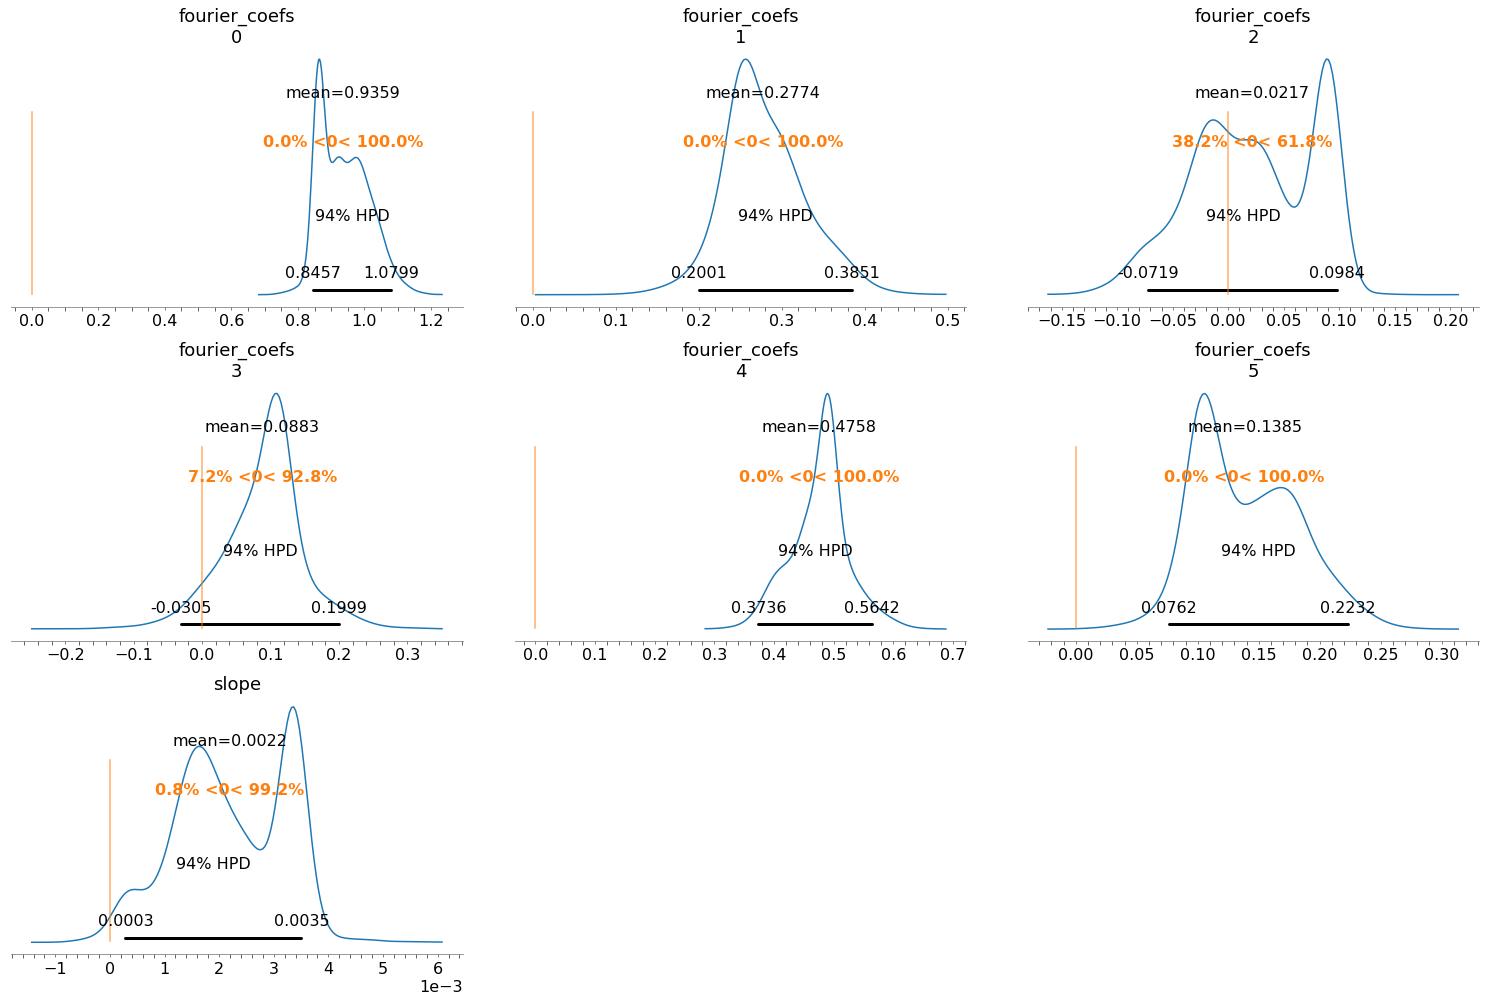

In [64]:
pm.plot_posterior(trace_m4f3, var_names=vars_, ref_val=0, round_to=4);

In [65]:
m4_f4.name='trend&fourier4&ar1'
m4_f3.name='trend&fourier3&ar1'

In [68]:
ar.compare({m3_f3.name: trace_m3f3, m3_f4.name: trace_m3f4,
            m4_f4.name: trace_m4f4, m4_f3.name: trace_m4f3})

/accounts/ekarakoy/anaconda3/envs/bayesian_toa_project/lib/python3.7/site-packages/arviz/stats/stats.py:1078: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
trend&fourier3&ar1,-108.806,242.707,0,1,23.4745,0,True,deviance
trend&fourier4&ar1,-13.076,154.64,95.7297,6.90411e-21,23.4268,3.63066,True,deviance
m3_trend&fourierN4,448.018,10.5493,556.824,5.75305e-112,6.89987,19.5588,True,deviance
m3_trend&fourierN3,450.858,8.71287,559.663,1.79098e-112,6.47152,19.1925,False,deviance


Keeping the model with 4 fourier components:

In [ ]:
ts_mod_4 = trace_4.get_values('mu')
ts_mod_4_mu = ts_mod_4.mean(axis=0)
ts_mod_4_hpd = pm.hpd(ts_mod_4)
ts_mod_4_trend = trace_4.get_values('trend')
ts_mod_4_trend_mu = ts_mod_4_trend.mean(axis=0)
ts_mod_4_trend_hpd = pm.hpd(ts_mod_4_trend)
ts_mod_4_season = trace_4.get_values('season')
ts_mod_4_season_mu = ts_mod_4_season.mean(axis=0)
ts_mod_4_season_hpd = pm.hpd(ts_mod_4_season)
ts_mod_4_ar1 = trace_4.get_values('ar1')
ts_mod_4_ar1_mu = ts_mod_4_ar1.mean(axis=0)
ts_mod_4_ar1_hpd = pm.hpd(ts_mod_4_ar1)

In [ ]:
def plot_component(axi, x, y, hpd_=None, obs=None, line_label=None, y_axis_label=None,
                  ax_title=None):
    
    if isinstance(obs, np.ndarray):
        axi.plot(x, obs, color='k', label='observations')
    axi.plot(x, y, color='darkblue', label=line_label)
    if isinstance(hpd_, np.ndarray):
        axi.fill_between(x, hpd_[:, 0], hpd_[:, 1], color='steelblue',
                         alpha=0.5, label='95% CI')
    if y_axis_label:
        axi.set_ylabel(y_axis_label)
    axi.legend()
    if ax_title:
        axi.set_title(ax_title)
    axi.xaxis_date()
    axi.xaxis.set_major_locator(years)
    axi.xaxis.set_minor_locator(months)
    axi.tick_params(axis='x', labelrotation=30)
    axi.grid()

In [ ]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(12, 20))

ylbl = 'standardized chl'
plot_component(ax[0], d_aostz.index, ts_mod_4_mu, hpd_=ts_mod_4_hpd,
               obs=y_s, line_label='model_mean', y_axis_label=ylbl,
               ax_title='All Components')
plot_component(ax[1], d_aostz.index, ts_mod_4_trend_mu, hpd_=ts_mod_4_trend_hpd,
               line_label='mean', y_axis_label=ylbl, ax_title='Trend')
plot_component(ax[2], d_aostz.index, ts_mod_4_season_mu, hpd_=ts_mod_4_season_hpd,
               line_label='mean', y_axis_label=ylbl,
              ax_title='Season')
plot_component(ax[3], d_aostz.index, ts_mod_4_ar1_mu, hpd_=ts_mod_4_ar1_hpd,
              line_label='mean', y_axis_label=ylbl, ax_title='AR1')

#### Inverse transform results of models where standardized data was used

In [ ]:
mod4_mu_us = std_scaler.inverse_transform(ts_mod_4_mu)
mod4_hpd_us = std_scaler.inverse_transform(ts_mod_4_hpd)
mod4_trend_hpd_us = std_scaler.inverse_transform(ts_mod_4_trend_hpd)
mod4_trend_mu_us = std_scaler.inverse_transform(ts_mod_4_trend_mu)
mod4_season_hpd_us = std_scaler.inverse_transform(ts_mod_4_season_hpd)
mod4_season_mu_us = std_scaler.inverse_transform(ts_mod_4_season_mu)
mod4_ar1_hpd_us = std_scaler.inverse_transform(ts_mod_4_ar1_hpd)
mod4_ar1_mu_us = std_scaler.inverse_transform(ts_mod_4_ar1_mu)

In [ ]:
f, ax = pl.subplots(nrows=4, sharex=True, figsize=(15, 20))
plot_component(ax[0], d_aostz.index, mod4_mu_us, hpd_=mod4_hpd_us,
               obs=y, line_label='model_mean',
               y_axis_label='chl $(mg m^{-3})$', ax_title='All Components')
plot_component(ax[1], d_aostz.index, mod4_trend_mu_us, hpd_=mod4_trend_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Trend')
plot_component(ax[2], d_aostz.index, mod4_season_mu_us, hpd_=mod4_season_hpd_us,
               line_label='mean', y_axis_label='chl $(mg m^{-3})$',
              ax_title='Season')
plot_component(ax[3], d_aostz.index, mod4_ar1_mu_us, hpd_=mod4_ar1_hpd_us,
              line_label='mean', y_axis_label='chl $(mg m^{-3})$', ax_title='AR1')
f.subplots_adjust(hspace=0.15)

In [ ]:
f, axs = pl.subplots(ncols=2, figsize=(12, 4))
pm.plot_posterior(trace_4, var_names=['trend', 'k'], ax=axs, text_size=16, );
axs[0].set_title('trend')
axs[0].axvline(color='r')
axs[1].set_title('AR(1) coeff.');
#f.savefig('./figJar/model4_posterior_dists.png', dpi=300)

In [ ]:
y_m6 = y_ppc6.mean(axis=0)
hpd6 = pm.hpd(y_ppc6)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, y_m6, hpd_=hpd6,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

### Local linear trend modeling

In [ ]:
with pm.Model() as m7:
    delta_t = pm.GaussianRandomWalk('delta_t', mu=0, sd=1, shape=numobs-1)
    nu_t = pm.GaussianRandomWalk('nu_t', mu=delta_t, sd=1, shape=numobs)
    y_t = pm.Normal('y_t', mu=nu_t, sd=1, observed=y_s)

In [ ]:
with m7:
    trace_7 = pm.sample(5000, tune=5000)

In [ ]:
pm.traceplot(trace_7);

In [ ]:
y_ppc7 = pm.sample_ppc(trace_7, model=m7)['y_t']

In [ ]:
y_m7 = y_ppc7.mean(axis=0)
hpd7 = pm.hpd(y_ppc7)
_, ax = pl.subplots(figsize=(12, 6))
plot_component(ax, d_iostz.index, y_m7, hpd_=hpd7,
               obs=y_s, line_label='model_mean',
               y_axis_label='chl $(mg m^-3)$', ax_title='All Components')

In [71]:
m4_trend_fourier3_ar1 = ar.from_pymc3(trace_m4f3, 
                                     )
m4_trend_fourier4_ar1 = ar.from_pymc3(trace_m4f4,
                                     )

In [73]:
m4_trend_fourier3_ar1.to_netcdf('../../pickleJar/model_results_nc/m4_trend_f3_ar1.nc')

'../../pickleJar/model_results_nc/m4_trend_f3_ar1.nc'

In [74]:
m4_trend_fourier4_ar1.to_netcdf('../../pickleJar/model_results_nc/m4_trend_fourier4_ar1')

'../../pickleJar/model_results_nc/m4_trend_fourier4_ar1'


 #### <u>Piecewise trend model</u>